In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import ml_cca

In [2]:
good_files =[2,3,6,7,8,9,11,12,13,17,19,21,22,24,27,33,36,38,
                     40,41,42,45,46,52,54,56,61,64,65,68,69,70,71,74,76,80,82,84,88,89,90,91,95]

In [3]:
n_voxels = 91*109*91
T1_data = np.zeros((len(good_files),n_voxels))
fMRI_data = np.zeros((len(good_files),n_voxels))

# Load the data

In [4]:
k = 0
for i in good_files:
    in_file = "/RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/T1standardBL/SMART0%02dT1_BL_brain_flirt.nii.gz" %i
    img = nib.load(in_file)
    data = img.get_data()
    T1_data[k] = data.flatten()
    k = k+1
T1_data = T1_data.astype('float32')

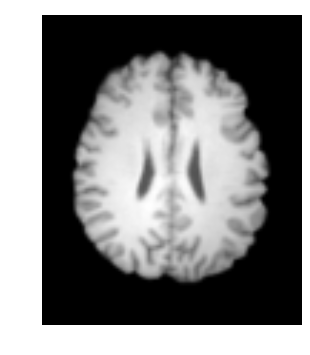

In [5]:
in_file = "/RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/T1standardBL/SMART070T1_BL_brain_flirt.nii.gz"
img = nib.load(in_file)
data = img.get_data()
plt.imshow(np.rot90(data[:,:,50]), 
               cmap="gray")
plt.gca().set_axis_off()

In [6]:
k = 0
for i in good_files:
    in_file = "/RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/func2standardBL/SMART0%02drsfMRI_BL_brain_mcf_flirt.nii.gz" %i
    img = nib.load(in_file)
    data = img.dataobj[...,100]
    fMRI_data[k] = data.flatten()
    k = k+1
fMRI_data = fMRI_data.astype('float32')

## Perform PCA to reduce dimensionality

In [7]:
from sklearn.decomposition import PCA

In [8]:
T1_pca = PCA(n_components =len(good_files)-1,whiten=True,svd_solver='randomized')

In [9]:
T1_data_reduced = T1_pca.fit_transform(T1_data)

In [10]:
fmri_pca = PCA(n_components =len(good_files)-1,whiten=True,svd_solver='randomized')

In [11]:
fMRI_data_reduced = fmri_pca.fit_transform(fMRI_data)

In [12]:
T1_pca.explained_variance_

array([  5.12445538e+09,   2.51091476e+09,   1.63680076e+09,
         1.31585680e+09,   9.21674670e+08,   7.87211876e+08,
         5.80728567e+08,   5.47585040e+08,   5.02074594e+08,
         4.71658324e+08,   3.95776364e+08,   3.58509609e+08,
         3.38646946e+08,   3.17800022e+08,   3.09687974e+08,
         2.83273698e+08,   2.76166651e+08,   2.62516587e+08,
         2.55051211e+08,   2.44607696e+08,   2.42422605e+08,
         2.35580697e+08,   2.08996108e+08,   2.05431475e+08,
         2.03703000e+08,   1.91940410e+08,   1.89245712e+08,
         1.82587616e+08,   1.73828167e+08,   1.71605021e+08,
         1.54276632e+08,   1.43168658e+08,   1.39655297e+08,
         1.32219487e+08,   1.25542035e+08,   1.22473909e+08,
         1.19385545e+08,   1.12298146e+08,   1.09449572e+08,
         1.04240216e+08,   9.89189619e+07,   9.26460526e+07])

In [13]:
T1_pca.components_[0]

array([ -2.53753672e-18,  -5.21131906e-18,  -7.35392991e-18, ...,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00])

In [14]:
cca = ml_cca.MaximumLikelihoodCCA(len(good_files)-1)

In [15]:
cca.fit(fMRI_data_reduced,T1_data_reduced)

In [16]:
cca.transform()

ml_cca.py:135: RuntimeWarning: divide by zero encountered in reciprocal
  diff_Pd_inv = np.reciprocal(np.ones((self.n_components)) - np.square(self.Pd))


In [17]:
cca.Pd

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

In [18]:
cca.E_z_y

array([[ 0.36387721, -0.01006988, -0.19427545, ..., -0.13054763,
        -0.00595378,  0.05805511],
       [ 0.17080886,  0.073573  ,  0.07876739, ...,  0.25989253,
        -0.24289451, -0.03900078],
       [ 0.25604289, -0.06361315, -0.1909877 , ..., -0.24943573,
         0.28117103, -0.335169  ],
       ..., 
       [-0.06136259,  0.03827992,  0.08070924, ...,  0.07579396,
         0.06045448,  0.13436542],
       [-0.1924668 , -0.11707913, -0.12228764, ..., -0.19999512,
         0.03163118, -0.21170593],
       [ 0.06407002, -0.35911363, -0.01261559, ...,  0.03296269,
        -0.00171003, -0.19640088]])